# Librerías necesarias

In [1]:
import sys
sys.path.append('../..')

from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve

import matplotlib.pyplot as plt

# Carga de datos

In [2]:
# Path al directorio donde tenemos los datasets con las reviews
# ¡Descomprimir antes!
datasets_path = '../../datasets'
corpus_cine_folder = 'corpusCine'

In [3]:
reviews_dict = load_cinema_reviews(datasets_path, corpus_cine_folder)

In [4]:
reviews_dict.get(10)

{'author': 'Javier Moreno',
 'title': 'Harry poter y el caliz de fuego',
 'sentiment': '4',
 'summary': 'Interesante adaptación de la novela de Rowling',
 'review_text': 'No. Esta vez no voy a usar una película como pretexto para exponer mis ideas o pensamientos mas dementes/racionales/insensatos. Esta vez, y lo juro ante el sagrado Necronomicón de Lovecraft, pienso hablar de la película en si (por primera vez y esperando que no sirva de precedente), aunque creo que es evidente que prefiero que una película me haga reflexionar sobre cualquier aspecto que en ella se de cita. Quizas algún dia hable sobre todo lo que significa la saga de novelas de Rowling (anda que no tengo cosas de las que hablar) desde una perspectiva menos mitológica y mas profunda.Parto de la base de que soy un autentico fan de los libros, los adoro, me parecen de lo mejorcito que ha salido en fantasia, con un personaje principal realmente interesante y atormentado a todos los niveles por todo lo que su no-existencia

In [5]:
reviews_text = []
reviews_sentiment = []

for review in reviews_dict.values():
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('sentiment'))

df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})
df.dropna(subset=['review', 'sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.head()

,review,sentiment
0,Cada vez me gusta menos el cine de masas. Las ...,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3
2,"Es que no la cagan en ninguna, todas las pelis...",5
3,Es un dolor esto del cine. Yo ya voy con miedo...,2
4,"Tras una insufrible primera media hora, la cas...",2


In [7]:
set(df['sentiment'])

{'1', '2', '3', '4', '5'}

In [11]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 0
    else:
        return 1

In [12]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [15]:
df.head(5)

,review,sentiment,sentiment_label
0,Cada vez me gusta menos el cine de masas. Las ...,1,0
1,"El otro dia fui a ver ""la de los sioux"" como d...",3,1
2,"Es que no la cagan en ninguna, todas las pelis...",5,1
3,Es un dolor esto del cine. Yo ya voy con miedo...,2,0
4,"Tras una insufrible primera media hora, la cas...",2,0


# Separamos en conjunto de train y test

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [25]:
X_train.iloc[:10]

1924    Zhang Yimou ya no es el poeta de lo íntimo, el...
3250    Las aventuras amorosas del joven Molire es el ...
1620    El cientifismo naturalista es un género cinema...
907     Quizá esperaba una crítica más demoledora del ...
1864    Colateral de Michael Mann desnuda con claridad...
3007    No es Gracia Querejeta una directora a la que ...
1583    Esta es una de esas extrañas películas que emp...
370     Suele ocurrir que cuando alguien pone las expe...
2045    Vivian vive en Bucarest, trabaja en una tienda...
3601    Algunos filmes pasan a ser de culto por un hec...
Name: review, dtype: object

In [26]:
y_train.iloc[:10]

1924    1
3250    1
1620    0
907     0
1864    1
3007    1
1583    1
370     1
2045    0
3601    0
Name: sentiment_label, dtype: int64

# Extracción de features

In [41]:
cv = TfidfVectorizer(
    ngram_range=(2, 3),
    strip_accents='ascii',
    max_df=0.95,
    min_df=3,
    max_features=3000
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=3000, min_df=3, ngram_range=(2, 3),
                strip_accents='ascii')

In [42]:
len(cv.vocabulary_.items())

3000

## TF-IDF scores del training set y test set

In [43]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Score IDF de algunas palabras

In [39]:
words_example = [
    'cine',
    'película',
    'muy',
    'y',
    'de',
    'que',
    'potter',
    'mala',
    'aburrimiento',
    'sorprendente',
    'aburrir',
    'ausdf'
]

In [40]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
cine                1.556
película            OOV                 
muy                 1.532
y                   OOV                 
de                  OOV                 
que                 OOV                 
potter              5.005
mala                3.155
aburrimiento        4.727
sorprendente        4.275
aburrir             OOV                 
ausdf               OOV                 


## Palabras con el TF-IDF en alguna review

In [44]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 2894
Sentiment: 1
Review: Tengo una tremenda perra con esa expresión, "tolerancia", referida a los inmigrantes. Siendo mejor que la intolerancia, por supuesto, no creo que ser tolerantes con los extranjeros y con las personas de otro color y otra raza sea suficiente. Tolerancia significa soportar, admitir y aguantar que existan, pero nada más. Significa dejarlos apartados, no mezclarse con ellos, trazar una línea divisoria que nos separe. Nosotros aquí y vosotros ahí, quietecitos y sin incordiar.Sin embargo, hay un barrio en Madrid, Lavapiés, que ha dado un paso que va mucho más allá de la tolerancia, tal y como el grandioso Fernando Colomo nos cuenta en su deliciosa, refrescante, utópica, desenfadada y feliz película "El próximo oriente."Ahora que la cartelera agoniza, con el único soporte de los piratas del Caribe, todos los que aguantamos en agosto en las ciudades y todos los que vuelven de sus vacaciones deberíamos ir en manada a disfrutar con una de las comedias más inteligent

In [47]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 15
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 15 words with highest TF_IDF in the review 2894:
                       tfidf
que quiere          0.188620
lo hace             0.157347
con el              0.123174
de los              0.111900
las comedias        0.111454
piratas del         0.110464
piratas del caribe  0.110464
de una familia      0.109985
del caribe          0.109060
como el             0.108957
de lleno            0.108612
un pais             0.108612
de las grandes      0.108173
ahora que           0.107743
los secundarios     0.107322

Top 15 words with lowest TF_IDF in the review 2894:
                 tfidf
en las        0.051707
de sus        0.048957
uno de        0.048427
de la         0.046739
en los        0.045334
es un         0.041564
en su         0.041564
no es         0.041545
con la        0.039833
es una        0.039400
una pelicula  0.039179
de una        0.035913
de un         0.034437
que no        0.032111
lo que        0.031405


## $\chi²$ scores

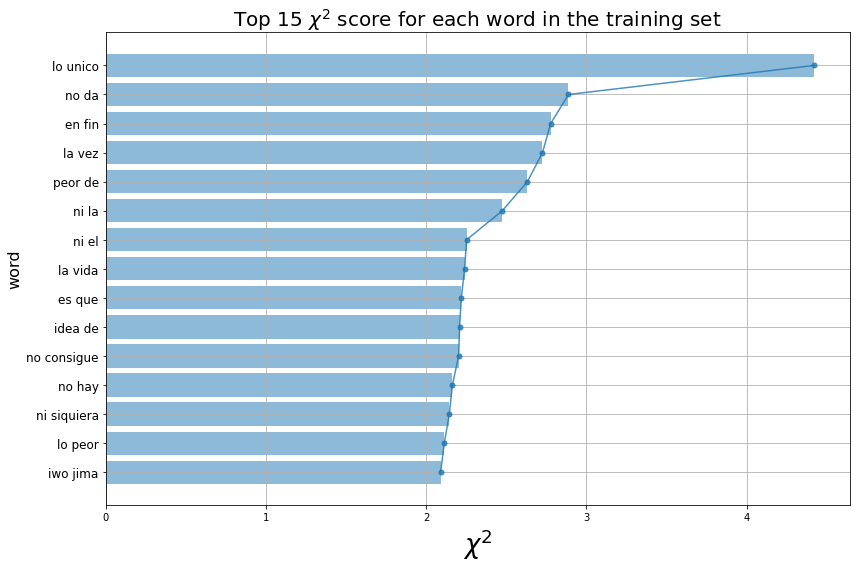

In [48]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Entrenamiento

In [49]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6597938144329897
Accuracy for C=0.05: 0.6597938144329897
Accuracy for C=0.25: 0.6649484536082474
Accuracy for C=0.5: 0.6958762886597938
Accuracy for C=1: 0.7288659793814433
Accuracy for C=10: 0.7391752577319588
Accuracy for C=100: 0.7072164948453609
Accuracy for C=1000: 0.7
Accuracy for C=10000: 0.7


# Algunas métricas

In [50]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[183 147]
 [144 496]]

Classification report:
              precision    recall  f1-score   support

           0       0.56      0.55      0.56       330
           1       0.77      0.78      0.77       640

    accuracy                           0.70       970
   macro avg       0.67      0.66      0.67       970
weighted avg       0.70      0.70      0.70       970

Accuracy score:0.7


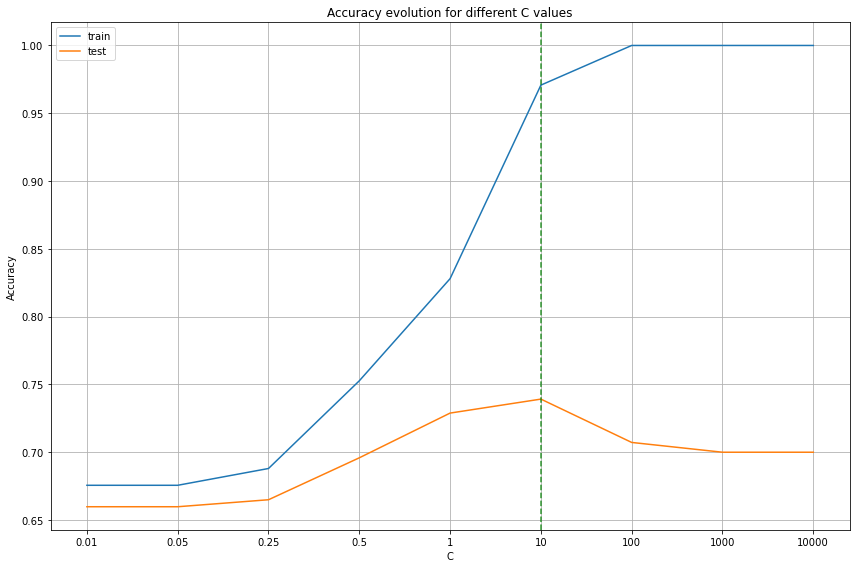

In [51]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

# Predict

In [52]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [53]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 1727
Actual sentiment: 1
Prediction: [1]

Review no. 118
Actual sentiment: 1
Prediction: [1]

Review no. 2607
Actual sentiment: 0
Prediction: [0]

Review no. 1637
Actual sentiment: 1
Prediction: [1]

Review no. 1291
Actual sentiment: 1
Prediction: [1]
